In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import mne
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands, get_raw_power_bands

In [2]:
ONE_DRIVE = 'C:/Users/seand/Baylor College of Medicine/Haneef, Zulfi - Adel_shared'
exp_data = pd.read_excel(f'{ONE_DRIVE}/RNS Project Data 2021.xlsx', 'Data')

In [3]:
pts_w_control = [103, 110, 111, 112, 113, 115]
x_axis = np.arange(len(pts_w_control))
data_w_control = exp_data[exp_data['Participant_Number'].isin(pts_w_control)]
color1 = np.where(data_w_control['V1_Stim'] == 1, 'orange', 'royalblue')
color2 = np.where(data_w_control['V2_Stim'] == 1, 'orange', 'royalblue')
plt.bar(x_axis - 0.2, data_w_control['V1_HVLT_Delay_Raw'], 0.4, color=color1)
plt.bar(x_axis + 0.2, data_w_control['V2_HVLT_Delay_Raw'], 0.4, color=color2)
plt.legend(['Stim', 'Sham'])
plt.ylabel('HVLT Delay Raw Score')
plt.xticks(x_axis, pts_w_control)
plt.xlabel('Patient Number')
plt.title('Effect of Stimulation on Memory')
plt.plot()


[]

Currently, I am comparing the averaged powers across all channels and all frequencies within each band. Here is an illustration of what that looks like:

![](psd_ecog.png)

TODO average each channel across participants

In [6]:
def get_power_bands(pt_num, stim, picks=None):
    '''gets power bands given a patient number and stimulated/control'''
    if stim != 'stimulated' and stim != 'control':
        raise ValueError("stim should be 'stimulated' or 'control'")
    
    raw = mne.io.read_raw_fif(f"data/{pt_num}/{stim}_ieeg.fif")
    try:
        saved_ann = mne.read_annotations(f"data/{pt_num}/{stim}_shocks_bad.csv")
        raw.set_meas_date(0)
        raw.set_annotations(saved_ann)
    except IndexError:
        # gets thrown if the annotations CSV is empty, which is true for many of the control recordings
        pass

    # making the channel names uniform to make graphing easier
    # assumes that all mesial temporal electrodes must be in the hippocampus
    if pt_num == 113:
        raw.rename_channels({'LH1 - LH2': 'LHip1 - LHip2', 'LH3 - LH4': 'LHip3 - LHip4', 'RH1 - RH2': 'RHip1 - RHip2', 'RH3 - RH4': 'RHip3 - RHip4'})

    return get_raw_power_bands(raw, picks)
    

In [7]:
results = pd.DataFrame(columns=['ID', 'Stim', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
results.loc[:,'Stim'] = results['Stim'].astype('bool')
mne.set_log_level('WARNING')
for pt_num in pts_w_control:
    results = results.append({'ID': pt_num, 'Stim': False, **get_power_bands(pt_num, 'control')}, ignore_index=True)
    results = results.append({'ID': pt_num, 'Stim': True, **get_power_bands(pt_num, 'stimulated')}, ignore_index=True)
results


ID   Stim         Delta         Theta         Alpha          Beta  \
0   103  False  1.196043e-10  3.873209e-11  2.469912e-11  1.138123e-11   
1   103   True  5.191111e-11  2.530036e-11  1.874947e-11  8.229781e-12   
2   110  False  3.087605e-11  3.018558e-11  2.272969e-11  1.121892e-11   
3   110   True  2.151298e-10  2.258450e-10  1.023369e-10  3.689382e-11   
4   111  False  1.431405e-11  3.397360e-11  2.149670e-11  6.725230e-12   
5   111   True  8.892426e-11  9.588888e-11  5.186628e-11  1.528410e-11   
6   112  False  1.059094e-10  3.529303e-11  2.691985e-11  8.613035e-12   
7   112   True  9.931270e-11  2.772145e-11  1.341907e-11  6.214095e-12   
8   113  False  3.138012e-10  3.328542e-10  1.788671e-10  6.350518e-11   
9   113   True  3.389726e-10  4.717848e-10  2.647210e-10  7.194204e-11   
10  115  False  2.814415e-10  6.480111e-11  3.951444e-11  1.123611e-11   
11  115   True  2.902007e-10  4.558155e-11  2.412807e-11  6.354364e-12   

           Gamma  
0   9.508768e-13  
1   7.624224e-13  
2   6.176648e-13  
3   1.560508e-12  
4   7.392728e-13  
5   8.656735e-13  
6   1.160873e-12  
7   1.244221e-12  
8   3.968840e-12  
9   3.925692e-12  
10  8.864300e-13  
11  7.336811e-13

In [8]:
def compare_power(freq, ax=plt):
    if freq not in results.columns:
        raise ValueError('freq must be Delta, Theta, Alpha, Beta, or Gamma')
    
    x_axis = np.arange(len(results['ID'].unique()))
    ax.bar(x_axis - 0.2, results[~results['Stim']][freq], 0.4, label='Sham', color='royalblue')
    ax.bar(x_axis + 0.2, results[results['Stim']][freq], 0.4, label='Stim', color='orange')
    try:
        ax.xticks(x_axis, pts_w_control)
        ax.xlabel('Patient Number')
        ax.title(f"{freq} Power")
    except AttributeError:
        ax.set_xticks(x_axis, minor=False)
        ax.set_xticklabels(pts_w_control, minor=False)
        ax.set_xlabel('Patient Number')
        ax.set_title(f"{freq} Power")
    ax.legend()


In [9]:
# all together now
fig, axs = plt.subplots(2, 3)
compare_power('Delta', axs[0, 0])
compare_power('Theta', axs[0, 1])
compare_power('Alpha', axs[0, 2])
compare_power('Beta', axs[1, 0])
compare_power('Gamma', axs[1, 1])
fig.set_size_inches(12, 10)

# Scatter Plots

According to John, the graph above suggests that increased theta power during stim (compared to sham) appears to be correlated with memory improvements. Let's draw a scatter plot to confirm.

In [10]:
def calc_pct_changes(freq_band):
    stim = results[results['Stim'] == True ][['ID', freq_band]].set_index('ID')
    sham = results[results['Stim'] == False][['ID', freq_band]].set_index('ID')
    pct_changes = (stim - sham) / sham * 100
    return pct_changes

In [55]:
pct_changes_theta = calc_pct_changes('Theta')
stim_w_id = np.where(exp_data[['Participant_Number','V1_Stim']], exp_data[['Participant_Number', 'V1_HVLT_Delay_Raw']], exp_data[['Participant_Number', 'V2_HVLT_Delay_Raw']])
stim_w_id.transpose()
stim_w_id = pd.DataFrame(stim_w_id, columns=['ID', 'Memory_Stim'])
sham_w_id = np.where(exp_data[['Participant_Number','V1_Stim']], exp_data[['Participant_Number', 'V2_HVLT_Delay_Raw']], exp_data[['Participant_Number', 'V1_HVLT_Delay_Raw']])
sham_w_id.transpose()
sham_w_id = pd.DataFrame(sham_w_id, columns=['ID', 'Memory_Sham'])
memory_data = stim_w_id.merge(sham_w_id, left_on='ID', right_on='ID')
memory_data_w_control = memory_data[memory_data['ID'].isin(pts_w_control)]
raw_changes_memory = memory_data_w_control['Memory_Stim'] - memory_data_w_control['Memory_Sham']
plt.scatter(pct_changes_theta, raw_changes_memory)
plt.xlabel('Percent change in Theta Power')
plt.ylabel('Raw change in HVLT')

m, b, r, p_value, std_err = scipy.stats.linregress(pct_changes_theta['Theta'], raw_changes_memory)
plt.plot(pct_changes_theta['Theta'], m*pct_changes_theta['Theta']+b)
print(f'r = {r}, P = {p_value}')

r = 0.20116595343497068, P = 0.7023214356803922


To confirm, let's check the R and P-values for the other frequency bands

In [56]:
pct_changes_beta = calc_pct_changes('Beta')
m, b, r, p_value, std_err = scipy.stats.linregress(pct_changes_beta['Beta'], raw_changes_memory)
print(f'Beta: r = {r}, P = {p_value}')

pct_changes_alpha = calc_pct_changes('Alpha')
m, b, r, p_value, std_err = scipy.stats.linregress(pct_changes_alpha['Alpha'], raw_changes_memory)
print(f'Alpha: r = {r}, P = {p_value}')

pct_changes_delta = calc_pct_changes('Delta')
m, b, r, p_value, std_err = scipy.stats.linregress(pct_changes_delta['Delta'], raw_changes_memory)
print(f'Delta: r = {r}, P = {p_value}')

pct_changes_gamma = calc_pct_changes('Gamma')
m, b, r, p_value, std_err = scipy.stats.linregress(pct_changes_gamma['Gamma'], raw_changes_memory)
print(f'Gamma: r = {r}, P = {p_value}')

Beta: r = 0.4615793796276191, P = 0.35680194878581734
Alpha: r = 0.3367775241482775, P = 0.513932215752049
Delta: r = 0.606673762587159, P = 0.20163342173440318
Gamma: r = 0.0468771330072954, P = 0.9297358059326382


Interesting, Delta actually shows the highest correlation coefficient. Let's take a look at the graph for memory vs change in delta power to see if there are any outliers causing this.

In [13]:
plt.scatter(pct_changes_delta, raw_changes_memory)
plt.xlabel('Percent change in Delta Power')
plt.ylabel('Raw change in HVLT')
m, b, r, p_value, std_err = scipy.stats.linregress(pct_changes_delta['Delta'], raw_changes_memory)
plt.plot(pct_changes_delta['Delta'], m*pct_changes_delta['Delta']+b)

In [14]:
def compare_bands_for_pt(pt_num, ax=plt, chan=None):
    freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    x_axis = np.arange(len(freqs))

    src_df = results if chan is None else results_by_chan
    chan_picker = True if chan is None else (src_df['Channel'] == chan)
    ax.bar(x_axis - 0.2, src_df[~src_df['Stim'] & chan_picker].loc[src_df['ID'] == pt_num,'Delta':'Gamma'].squeeze(), 0.4, label='Sham', color='royalblue')
    ax.bar(x_axis + 0.2, src_df[src_df['Stim'] & chan_picker].loc[src_df['ID'] == pt_num,'Delta':'Gamma'].squeeze(), 0.4, label='Stim', color='orange')
    
    try:
        ax.xticks(x_axis, freqs)
        ax.xlabel('Frequency')
        ax.title(f"Patient {pt_num}")
    except AttributeError:
        ax.set_xticks(x_axis, minor=False)
        ax.set_xticklabels(freqs, minor=False)
        ax.set_xlabel('Frequency')
        ax.set_title(f"Patient {pt_num}")
    ax.legend()

In [15]:
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        compare_bands_for_pt(pts_w_control[i*3+j], axs[i][j])
fig.set_size_inches(12, 10)

Patient 103 is clearly different from 110 and 111 in their responses to stimulation, even though they all had improved memory scores. One possible explanation is that 103 is the only patient with the implant in the insula instead of the hippocampus.

In [16]:
results_by_chan = pd.DataFrame(columns=['ID', 'Stim', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
results_by_chan.loc[:,'Stim'] = results_by_chan['Stim'].astype('bool')
pts_w_hip = pts_w_control[1:] # should remove pt 103, who has the leads placed somewhere other than hippocampus
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
mne.set_log_level('WARNING')
for pt_num in pts_w_hip:
    for ch in hip_chans:
        results_by_chan = results_by_chan.append({'ID': pt_num, 'Stim': False, 'Channel': ch, **get_power_bands(pt_num, 'control', picks=ch)}, ignore_index=True)
        results_by_chan = results_by_chan.append({'ID': pt_num, 'Stim': True, 'Channel': ch, **get_power_bands(pt_num, 'stimulated', picks=ch)}, ignore_index=True)
results_by_chan

ID   Stim        Channel         Delta         Theta         Alpha  \
0   110  False  LHip1 - LHip2  1.990531e-11  1.875831e-11  1.072189e-11   
1   110   True  LHip1 - LHip2  6.198028e-11  3.631905e-11  2.014082e-11   
2   110  False  LHip3 - LHip4  5.208236e-11  4.562758e-11  4.061134e-11   
3   110   True  LHip3 - LHip4  6.193237e-10  6.111209e-10  2.576948e-10   
4   110  False  RHip1 - RHip2  3.187319e-11  2.979816e-11  1.726610e-11   
5   110   True  RHip1 - RHip2  8.026129e-11  1.382150e-10  6.934819e-11   
6   110  False  RHip3 - RHip4  1.964335e-11  2.655829e-11  2.231943e-11   
7   110   True  RHip3 - RHip4  9.895390e-11  1.177252e-10  6.216391e-11   
8   111  False  LHip1 - LHip2  1.712418e-11  2.939658e-11  1.346716e-11   
9   111   True  LHip1 - LHip2  3.020451e-10  2.918542e-10  1.464114e-10   
10  111  False  LHip3 - LHip4  1.109588e-11  3.345054e-11  3.788533e-11   
11  111   True  LHip3 - LHip4  2.334114e-11  3.376200e-11  3.101765e-11   
12  111  False  RHip1 - RHip2  8.270377e-12  1.110333e-11  6.725609e-12   
13  111   True  RHip1 - RHip2  9.815307e-12  1.508399e-11  6.835625e-12   
14  111  False  RHip3 - RHip4  2.076576e-11  6.194393e-11  2.790868e-11   
15  111   True  RHip3 - RHip4  2.049549e-11  4.285529e-11  2.320042e-11   
16  112  False  LHip1 - LHip2  6.514627e-11  1.720683e-11  8.876065e-12   
17  112   True  LHip1 - LHip2  8.076979e-11  1.679936e-11  8.097521e-12   
18  112  False  LHip3 - LHip4  4.512021e-11  4.476910e-11  6.126555e-11   
19  112   True  LHip3 - LHip4  4.454015e-11  1.888275e-11  1.699668e-11   
20  112  False  RHip1 - RHip2  1.482859e-10  4.326464e-11  2.194539e-11   
21  112   True  RHip1 - RHip2  7.853787e-11  3.554237e-11  1.944894e-11   
22  112  False  RHip3 - RHip4  1.650850e-10  3.593154e-11  1.559239e-11   
23  112   True  RHip3 - RHip4  1.934030e-10  3.966133e-11  9.133149e-12   
24  113  False  LHip1 - LHip2  2.398915e-10  1.591977e-10  1.491719e-10   
25  113   True  LHip1 - LHip2  1.650237e-10  1.179922e-10  9.651443e-11   
26  113  False  LHip3 - LHip4  4.814205e-11  5.772960e-11  3.126367e-11   
27  113   True  LHip3 - LHip4  3.044859e-11  2.607623e-11  1.437337e-11   
28  113  False  RHip1 - RHip2  5.958384e-10  6.471843e-10  3.202776e-10   
29  113   True  RHip1 - RHip2  9.822879e-10  1.411925e-09  7.287015e-10   
30  113  False  RHip3 - RHip4  3.713329e-10  4.673053e-10  2.147553e-10   
31  113   True  RHip3 - RHip4  1.781300e-10  3.311460e-10  2.192948e-10   
32  115  False  LHip1 - LHip2  2.609418e-10  6.292894e-11  3.418602e-11   
33  115   True  LHip1 - LHip2  2.692647e-10  3.973662e-11  1.733600e-11   
34  115  False  LHip3 - LHip4  7.281549e-11  3.687073e-11  3.158294e-11   
35  115   True  LHip3 - LHip4  7.105917e-11  2.647858e-11  2.445692e-11   
36  115  False  RHip1 - RHip2  4.212112e-10  9.272505e-11  5.450422e-11   
37  115   True  RHip1 - RHip2  3.781871e-10  6.316303e-11  2.641995e-11   
38  115  False  RHip3 - RHip4  3.707976e-10  6.667972e-11  3.778461e-11   
39  115   True  RHip3 - RHip4  4.422919e-10  5.294796e-11  2.829942e-11   

            Beta         Gamma  
0   5.222807e-12  3.564607e-13  
1   1.288907e-11  8.682320e-13  
2   2.404270e-11  7.120127e-13  
3   9.105385e-11  2.696955e-12  
4   9.257452e-12  5.666839e-13  
5   2.680622e-11  1.335279e-12  
6   6.352706e-12  8.355019e-13  
7   1.682612e-11  1.341566e-12  
8   6.275637e-12  8.862831e-13  
9   3.615805e-11  1.168892e-12  
10  6.636346e-12  6.967018e-13  
11  1.208360e-11  9.827708e-13  
12  3.785170e-12  8.120107e-13  
13  3.975224e-12  7.109985e-13  
14  1.020376e-11  5.620958e-13  
15  8.919531e-12  6.000325e-13  
16  4.788530e-12  1.096410e-12  
17  4.288389e-12  1.430261e-12  
18  9.653657e-12  5.269387e-13  
19  4.060663e-12  6.171145e-13  
20  1.379291e-11  2.021799e-12  
21  1.143937e-11  1.975105e-12  
22  6.217043e-12  9.983451e-13  
23  5.067962e-12  9.544050e-13  
24  6.547475e-11  2.691561e-12  
25  3.774931e-11  1.588969e-12  
26  2.293955e-11  1.852748e-12  
27  8

# Plotting by Channel

In [17]:
fig, axs = plt.subplots(2, 3)
pts_w_hip_filled = [None, *pts_w_hip]
for i in range(2):
    for j in range(3):
        compare_bands_for_pt(pts_w_hip_filled[i*3+j], axs[i][j], hip_chans[0])
fig.suptitle(hip_chans[0])
fig.set_size_inches(12, 10)

In [18]:
fig, axs = plt.subplots(2, 3)
pts_w_hip_filled = [None, *pts_w_hip]
for i in range(2):
    for j in range(3):
        compare_bands_for_pt(pts_w_hip_filled[i*3+j], axs[i][j], hip_chans[1])
fig.suptitle(hip_chans[1])
fig.set_size_inches(12, 10)

In [19]:
fig, axs = plt.subplots(2, 3)
pts_w_hip_filled = [None, *pts_w_hip]
for i in range(2):
    for j in range(3):
        compare_bands_for_pt(pts_w_hip_filled[i*3+j], axs[i][j], hip_chans[2])
fig.suptitle(hip_chans[2])
fig.set_size_inches(12, 10)

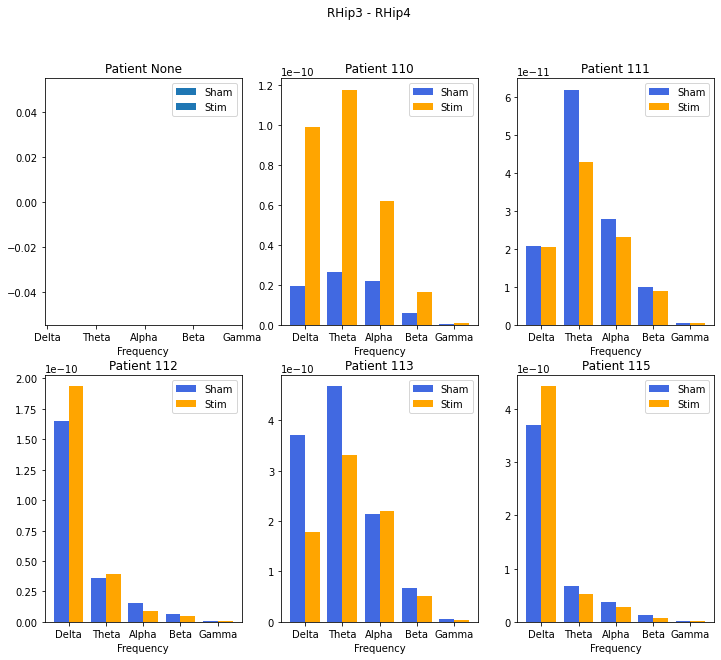

In [20]:
fig, axs = plt.subplots(2, 3)
pts_w_hip_filled = [None, *pts_w_hip]
for i in range(2):
    for j in range(3):
        compare_bands_for_pt(pts_w_hip_filled[i*3+j], axs[i][j], hip_chans[3])
fig.suptitle(hip_chans[3])
fig.set_size_inches(12, 10)

In [21]:
results_by_chan.to_excel('power_by_pt_and_channel.xlsx')

# Before Stim and Everything After

In [23]:
# these were selected by using the very first shock annotation
# except for one that started with a shock, in which case the second shock annotation was used
cutoff_times = [
    [103, 1.363727],
    [110, 4.595344],
    [111, 54.994776],
    [112, 16.115047],
    [113, 39.341517],
    [115, 83.482857]
]
cutoff_times = pd.DataFrame(cutoff_times, columns=['ID', 'tmax'])

In [24]:
def get_power_before_after_stim(pt_num):
    raw = read_with_annotations(pt_num)
    cutoff = cutoff_times[cutoff_times['ID'] == pt_num]['tmax'].item()
    delta = mne.time_frequency.psd_welch(raw, tmax=cutoff, fmin=1, fmax=3)[0].mean()
    theta = mne.time_frequency.psd_welch(raw, tmax=cutoff, fmin=4, fmax=7)[0].mean()
    alpha = mne.time_frequency.psd_welch(raw, tmax=cutoff, fmin=8, fmax=12)[0].mean()
    beta =  mne.time_frequency.psd_welch(raw, tmax=cutoff, fmin=13, fmax=30)[0].mean()
    gamma = mne.time_frequency.psd_welch(raw, tmax=cutoff, fmin=31, fmax=100)[0].mean()

    before = {
        'Delta': delta,
        'Theta': theta,
        'Alpha': alpha,
        'Beta': beta,
        'Gamma': gamma
    }

    delta = mne.time_frequency.psd_welch(raw, tmin=cutoff, fmin=1, fmax=3)[0].mean()
    theta = mne.time_frequency.psd_welch(raw, tmin=cutoff, fmin=4, fmax=7)[0].mean()
    alpha = mne.time_frequency.psd_welch(raw, tmin=cutoff, fmin=8, fmax=12)[0].mean()
    beta =  mne.time_frequency.psd_welch(raw, tmin=cutoff, fmin=13, fmax=30)[0].mean()
    gamma = mne.time_frequency.psd_welch(raw, tmin=cutoff, fmin=31, fmax=100)[0].mean()

    after = {
        'Delta': delta,
        'Theta': theta,
        'Alpha': alpha,
        'Beta': beta,
        'Gamma': gamma
    }

    return before, after

In [25]:
def compare_power_before_after(pt_num, ax=plt):
    before, after = get_power_before_after_stim(pt_num)
    x_axis = np.arange(len(before))
    ax.bar(x_axis - 0.2, before.values(), 0.4, color='royalblue')
    ax.bar(x_axis + 0.2, after.values(), 0.4, color='orange')
    ax.legend(['Before Stim', 'After Stim'])
    
    try:
        ax.xticks(x_axis, before.keys())
        ax.xlabel('Frequency')
        ax.title(f"Patient {pt_num}")
        ax.ylabel('Power')
    except AttributeError:
        ax.set_xticks(x_axis, minor=False)
        ax.set_xticklabels(before.keys(), minor=False)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Power')
        ax.set_title(f"Patient {pt_num}")

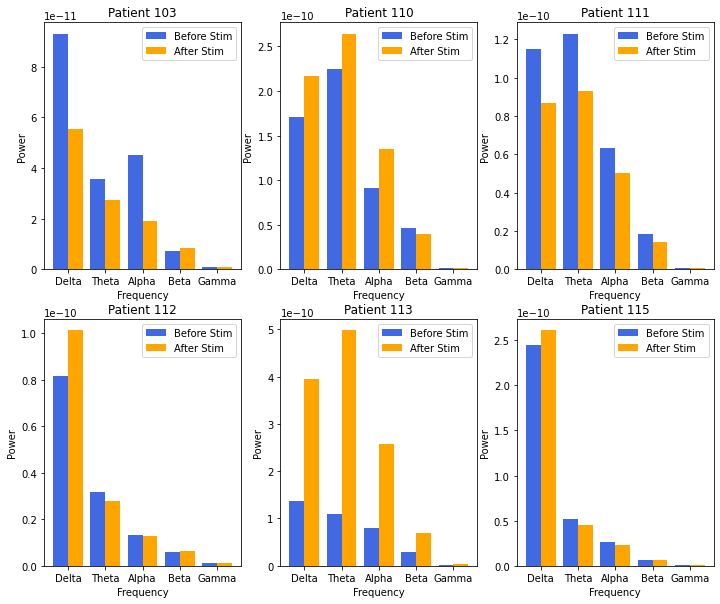

In [26]:
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        compare_power_before_after(pts_w_control[3*i+j], axs[i][j])
fig.set_size_inches(12, 10)

# Shortly Before Stim vs Shortly After

Some notes about the data:
- 103 will only have 1 usable trial due to short data in trials 2 and 3

Channel modifications:
- 100 has all of their implants in the left MT. They were originally labeled Hip1 - Hip2, Hip3 - Hip4, LatT1 - LatT2, and LatT3 - LatT4, but I changed the Hip to LHip so that I could compare with the others
- 113 had them labeld as LH and RH, but since their implants are bilateral MT, I changed them to LHip and RHip to match the naming scheme of the others. This may or may not be accurate.

These modifications were made in the Excel file by hand rather than by Python code. Earlier in the doc, there is one function that automatically renamed 113's channels.

In [114]:
pts_w_any_stim = [100, 103, 105, 110, 111, 112, 113, 115]

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    evts = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts[0], event_id=[1,2], tmin=0, tmax=2, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 2 seconds. May change tmax in the future
    epochs.drop_bad()
    trial_num = [i//2 + 1 for i in range(len(epochs.drop_log))]
    ids_dropped = []
    for idx, entry in enumerate(epochs.drop_log):
        if entry != ():
            ids_dropped.append(idx)
    print(epochs.drop_log)
    for dropped_so_far, idx in enumerate(ids_dropped):
        epochs.drop((idx - 1) - 2 * dropped_so_far)
        print(f'idx = {idx}')
        trial_num = trial_num[:max(idx - 2, 0)] + trial_num[idx + 1:]
    # if you ever need to debug, look at the drop logs
    # print(epochs.drop_log)
    print(ids_dropped, epochs)

    # the epochs are alternating pre and shock, so let's go comparing pairs 2 at a time
    for i in range(0, len(epochs), 2):
        for chan in epochs.ch_names:
            pre = get_multitaper_power_bands(epochs[i], picks=chan)
            post = get_multitaper_power_bands(epochs[i+1], picks=chan)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': False, 'Trial': trial_num[i], 'Channel': chan, **pre}, ignore_index=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': True, 'Trial': trial_num[i], 'Channel': chan, **post}, ignore_index=True)

results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 501 original time points ...
0 bad epochs dropped
((), (), (), (), (), ())
[] <Epochs |  6 events (all good), 0 - 2 sec, baseline 0.5 – 1 sec, ~10 kB, data not loaded,
 '1': 3
 '2': 3>
Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estim

ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  1.628325e-07  5.868435e-08   
1    100   True     1  LHip1 - LHip2  1.055776e-07  4.467946e-08   
2    100  False     1  LHip3 - LHip4  1.322027e-07  6.136439e-08   
3    100   True     1  LHip3 - LHip4  1.537812e-07  2.031031e-08   
4    100  False     1  LatT1 - LatT2  8.387676e-10  1.339907e-09   
..   ...    ...   ...            ...           ...           ...   
139  115   True     3  LHip3 - LHip4  1.110125e-08  6.126404e-09   
140  115  False     3  RHip1 - RHip2  4.655464e-08  1.696577e-08   
141  115   True     3  RHip1 - RHip2  8.858678e-08  2.528834e-08   
142  115  False     3  RHip3 - RHip4  4.671114e-08  1.471065e-08   
143  115   True     3  RHip3 - RHip4  9.089528e-08  1.306540e-08   

            Alpha          Beta         Gamma  
0    3.929592e-08  2.209333e-08  6.064164e-10  
1    4.283485e-08  2.331421e-08  6.780618e-10  
2    1.301731e-08  4.931129e-09  3.797266e-10  
3    1.194906e-08  4.284861e-09  4.966787e-10  
4    1.138691e-09  2.900681e-10  4.022826e-11  
..            ...           ...           ...  
139  3.342366e-09  1.010419e-09  8.811991e-11  
140  4.576373e-09  1.595297e-09  8.638585e-11  
141  6.624742e-09  2.496780e-09  1.053943e-10  
142  2.437432e-09  1.215204e-09  1.684019e-10  
143  3.224240e-09  1.737065e-09  1.622217e-10  

[144 rows x 9 columns]

In [116]:
with pd.ExcelWriter('power_before_after_v1.xlsx', mode='a') as writer:
    results_before_after.to_excel(writer, 'NewPowers')

So I drew a couple of graphs in Excel with the raw change in delayed memory on the Y-axis and the Percent change in Gamma Power on the X-axis. I used Pivot Tables so I could see the effect of each channel separately. (Note to Self: Pivot Table won't work well for total power because not correctly weighted). Ignoring the outlier of patient 111, there was basically no correlation for any of the graphs. Maybe there was a slight negative correlation, but there were so few patients that it was hard to tell what was spurious and what was significant.

Thinking how I could get more data points to see more of a pattern, I recalled that I was averaging the powers for all 3 trials. If I split up the trials and looked at the percent power change for each individually, it would put more dots on the graph and make it easier to see patterns. Unfortunately, the graphs looked just as No-Correlation as ever, and adding trendlines made it clear that most of them had very low R<sup>2</sup>

However, I realized that my dependent variable was the delayed memory scores. Ideally, this would be the best place to look, since it is where our statistically significant results came from last time, but when I was looking at power changes for individual trials, maybe it would make more sense to look at the scores for the individual trials. Although there was no significant correlation between stimulations *in general* and memory scores for each individual trial, it is possible that there could be a correlation between stimulations *that change power in a certain way*. This will be the next avenue of analysis.

In [8]:
def cols_i_need(visit):
    # visit should be either 1 or 2
    return ['Participant_Number', *[f'V{visit}_HVLT_Trial_{i}_Raw' for i in range(1,4)]]

stim_w_id = np.where(exp_data[['Participant_Number','V1_Stim', 'V1_Stim', 'V1_Stim']], exp_data[cols_i_need(1)], exp_data[cols_i_need(2)])
stim_w_id.transpose()
stim_w_id = pd.DataFrame(stim_w_id, columns=['ID', 'Trial_1_Stim', 'Trial_2_Stim', 'Trial_3_Stim'])
sham_w_id = np.where(exp_data[['Participant_Number','V1_Stim', 'V1_Stim', 'V1_Stim']], exp_data[cols_i_need(2)], exp_data[cols_i_need(1)])
sham_w_id.transpose()
sham_w_id = pd.DataFrame(sham_w_id, columns=['ID', 'Trial_1_Sham', 'Trial_2_Sham', 'Trial_3_Sham'])
memory_data_trials = stim_w_id.merge(sham_w_id, left_on='ID', right_on='ID')

In [131]:
raw = read_with_annotations(110)
chan = 'RHip3 - RHip4'
evts = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
epochs = mne.Epochs(raw, evts[0], event_id=[1,2], tmin=0, tmax=2, baseline=(0.5,1.0))

pre  = mne.time_frequency.psd_multitaper(epochs[4], fmin=1, fmax=3, picks=chan)[0].mean()
post = mne.time_frequency.psd_multitaper(epochs[5], fmin=1, fmax=3, picks=chan)[0].mean()

print(pre)
print(post)

# epochs[4].plot_psd(picks=chan, fmin=1, fmax=3, estimate='power', dB=False)
# epochs[5].plot_psd(picks=chan, fmin=1, fmax=3, estimate='power', dB=False)

Opening raw data file data/110/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 42983 =      0.000 ...   171.932 secs
Ready.
Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 501 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 501 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
4.755888926627863e-09
9.737809260798733e-09


In [161]:
w_psds, w_freqs = mne.time_frequency.psd_multitaper(epochs[3], picks='RHip3 - RHip4')
m_psds, m_freqs = mne.time_frequency.psd_multitaper(epochs[4], picks='RHip3 - RHip4')
fig, ax1 = plt.subplots()
ax1.set_title('Multitaper')
ax1.set_ylabel('$V^2/Hz$')
ax1.set_xlabel('Hz')
ax1.plot(w_freqs, w_psds.flatten(), label='Pre-stim')
ax2 = ax1.twinx()
ax2.set_ylabel('$V^2/Hz$')
ax2.plot(m_freqs, m_psds.flatten(), color='orange', label='Post-stim')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


Loading data for 1 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for ecog. Disabling interactivity.


C:\Users\seand\AppData\Local\Temp/ipykernel_21520/333914967.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs[4].plot_psd(picks='RHip3 - RHip4')


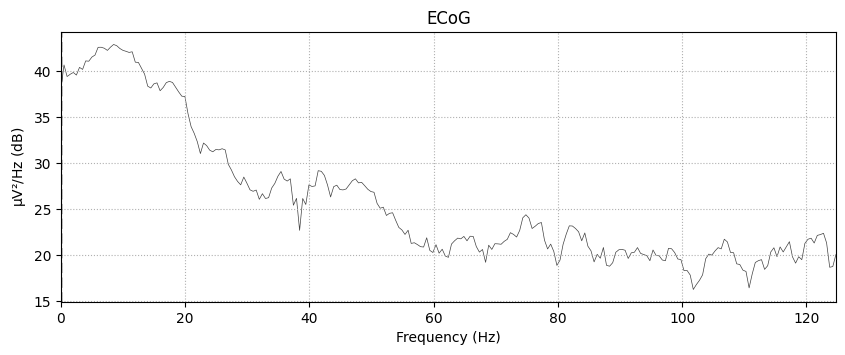

In [159]:
epochs[4].plot_psd(picks='RHip3 - RHip4')

(array([[[5.38447907e-09, 7.25529548e-09, 7.66292653e-09, 8.79374325e-09]]]), array([1.49700599, 1.99600798, 2.49500998, 2.99401198]))

(array([[[1.02032186e-07, 1.01753985e-07, 6.10231154e-08, 5.70408902e-08]]]), array([1.49700599, 1.99600798, 2.49500998, 2.99401198]))

In [19]:
num_ps = 0
new_arr = np.array([], dtype='<U10')
for desc in raw.annotations.description:
    if desc == 'post_shock':
        num_ps += 1
        if num_ps % 4 == 1:
            new_arr = np.append(new_arr, desc)
        else:
            new_arr = np.append(new_arr, 'after_shock')
    else:
        new_arr = np.append(new_arr, desc)
ann = mne.Annotations(raw.annotations.onset, raw.annotations.duration, new_arr, orig_time=raw.annotations.orig_time)
ann.save('data/105/stimulated_shocks_bad.csv', overwrite=True)

Overwriting existing file.


Opening raw data file data/103/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 58391 =      0.000 ...   233.564 secs
Ready.


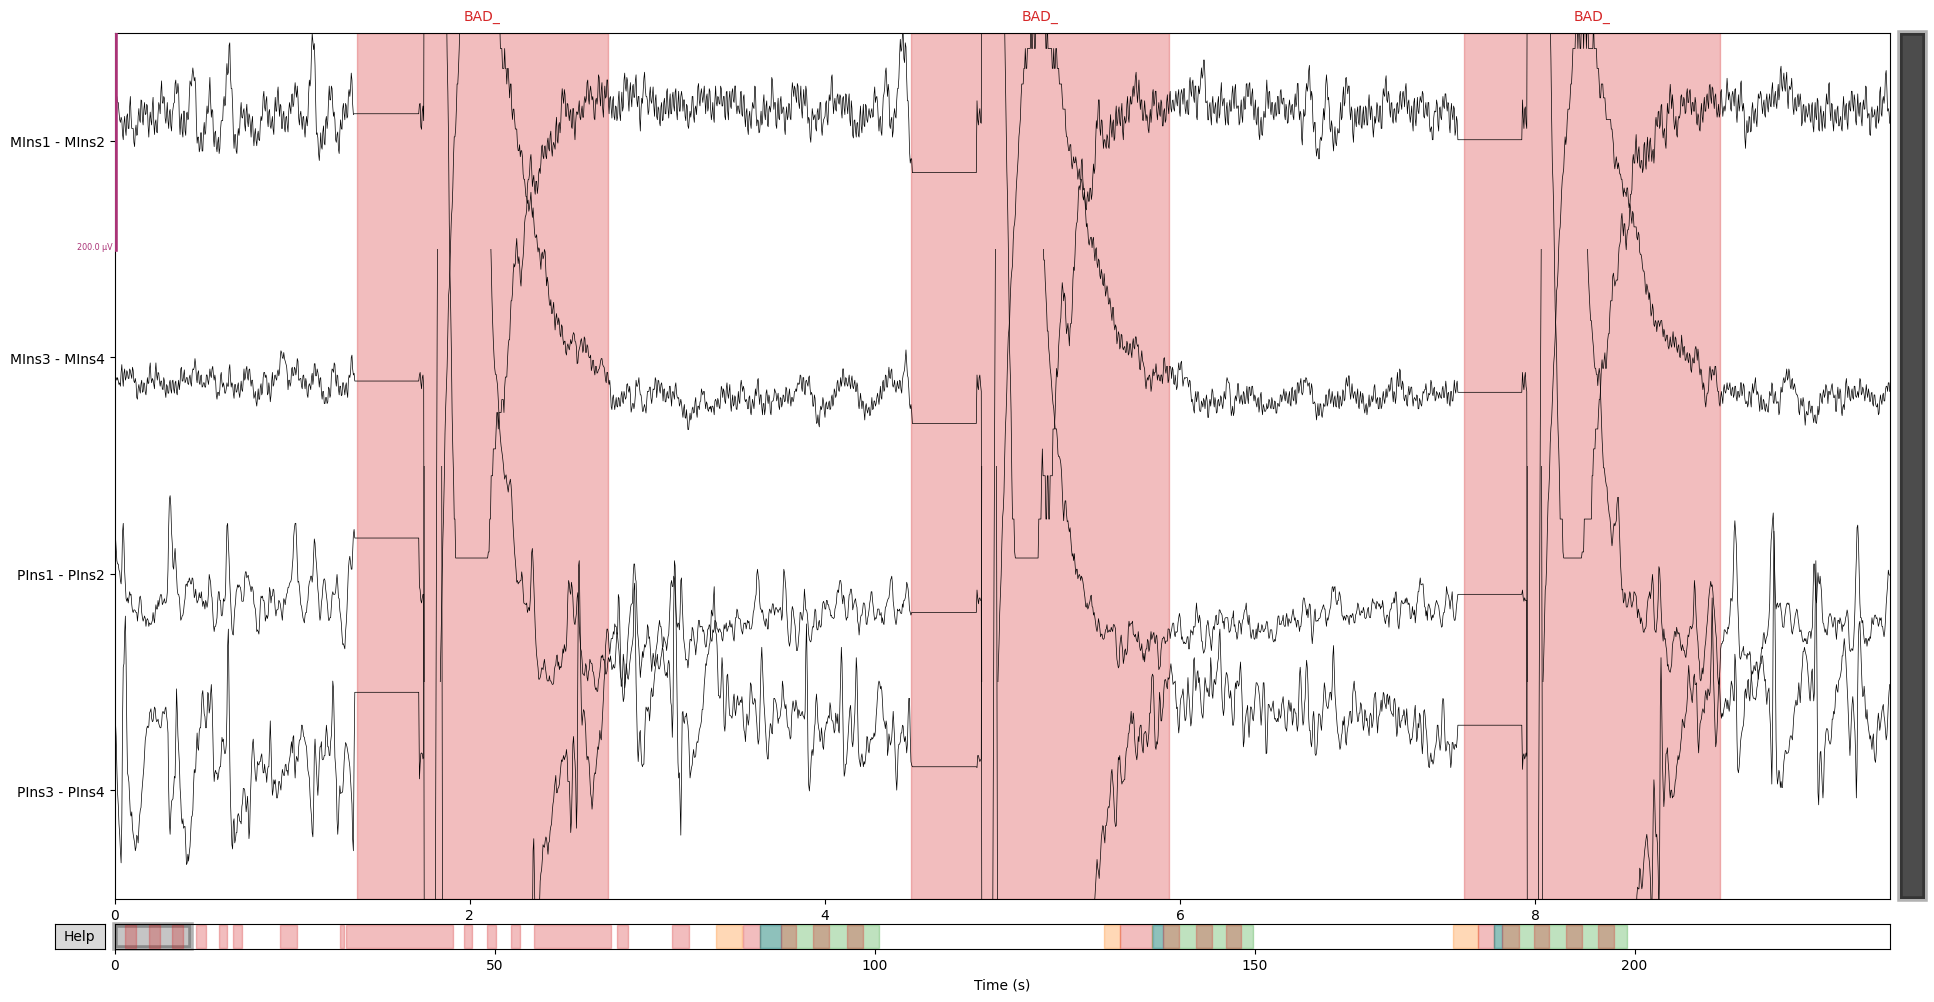

Channels marked as bad: none


In [17]:
raw = read_with_annotations(103)
# raw.pick_channels(['LH3 - LH4'])
raw.plot()

In [18]:
raw.annotations.save('data/103/stimulated_shocks_bad.csv', overwrite=True)

Overwriting existing file.


TODO
- 1:1 cut
- remove more of washout after-stim so that we can zero-mean
- add all 3 stims
- align trials
- sanity check data for outliers (PSD plots++)
- send summary email